<a href="https://colab.research.google.com/github/AlgorithmBurv/Prediction-IHSG/blob/main/IHSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import yfinance as yf

ticker = "^JKSE"  # Ticker untuk IHSG di Yahoo Finance
df = yf.download(ticker, period="5y", interval="1d")

/tmp/ipython-input-95-4208541628.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [96]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^JKSE,^JKSE,^JKSE,^JKSE,^JKSE
Date,,,,,
2020-07-02,4966.779785,4966.779785,4914.388184,4914.388184,55396200
2020-07-03,4973.793945,4997.481934,4964.107910,4966.779785,55723400
2020-07-06,4988.866211,5009.345215,4973.490234,4973.793945,64282100
2020-07-07,4987.082031,5011.712891,4982.333984,4988.866211,72834600
2020-07-08,5076.173828,5080.251953,4985.017090,4987.082031,73499000


In [97]:
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.reset_index(inplace=True)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1200 non-null   datetime64[ns]
 1   Close   1200 non-null   float64       
 2   High    1200 non-null   float64       
 3   Low     1200 non-null   float64       
 4   Open    1200 non-null   float64       
 5   Volume  1200 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 56.4 KB


In [99]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-07-02,4966.779785,4966.779785,4914.388184,4914.388184,55396200
1,2020-07-03,4973.793945,4997.481934,4964.107910,4966.779785,55723400
2,2020-07-06,4988.866211,5009.345215,4973.490234,4973.793945,64282100
3,2020-07-07,4987.082031,5011.712891,4982.333984,4988.866211,72834600
4,2020-07-08,5076.173828,5080.251953,4985.017090,4987.082031,73499000


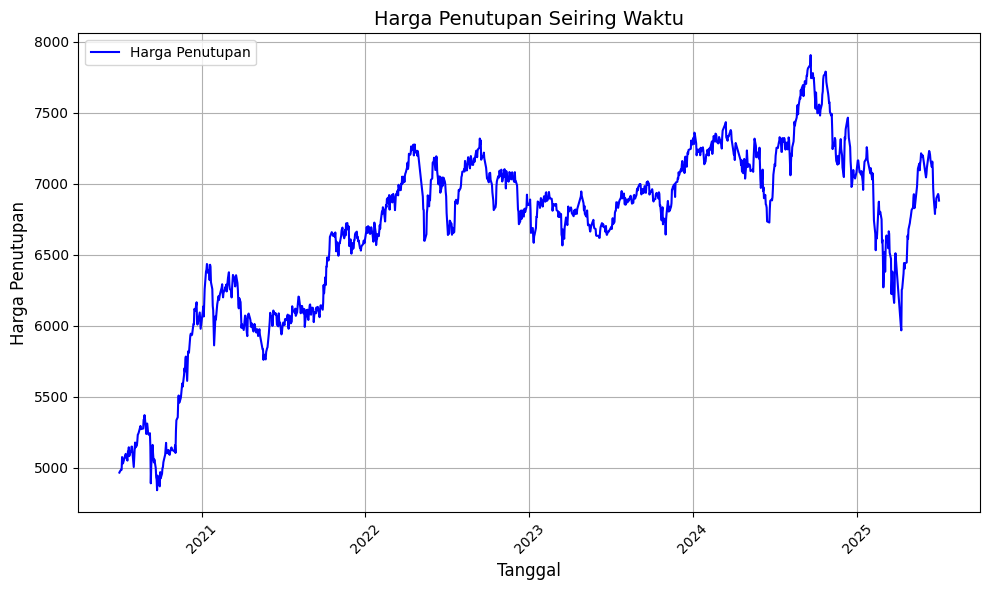

In [100]:
# Plot data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'], label='Harga Penutupan', color='blue')

# Menambahkan judul dan label
plt.title('Harga Penutupan Seiring Waktu', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Harga Penutupan', fontsize=12)

# Menampilkan grid dan legenda
plt.grid(True)
plt.legend()

# Menampilkan grafik
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [101]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Ambil harga penutupan
data_close = df[['Close']]

# Normalisasi data menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_close)

# Menampilkan beberapa data setelah normalisasi
print(scaled_data[:5])


[[0.04049583]
 [0.04278607]
 [0.04770741]
 [0.04712485]
 [0.07621477]]


In [102]:
# Splitting data (8:2)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Menyiapkan data dalam format LSTM
def create_dataset(data, interval_step=60):
    x, y = [], []
    for i in range(len(data) - interval_step - 1):
        x.append(data[i:(i + interval_step), 0])  # Menyusun fitur (harga saham sebelumnya)
        y.append(data[i + interval_step, 0])  # Harga saham di hari berikutnya
    return np.array(x), np.array(y)

# Membuat dataset untuk training dan testing
interval_step = 60
x_train, y_train = create_dataset(train_data, interval_step)
x_test, y_test = create_dataset(test_data, interval_step)

# Reshape data agar sesuai dengan input model LSTM [samples, time_steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")


x_train shape: (899, 60, 1), y_train shape: (899,)


In [103]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Membangun model LSTM
model = Sequential()

# Layer LSTM pertama
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout untuk mencegah overfitting

# Layer LSTM kedua
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer output untuk memprediksi satu nilai harga saham
model.add(Dense(units=1))  # Output satu nilai prediksi harga saham

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Menampilkan ringkasan model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
# Melatih model
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.1831
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0081
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0056
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0047
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0049
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0044
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0048
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0037
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0037


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


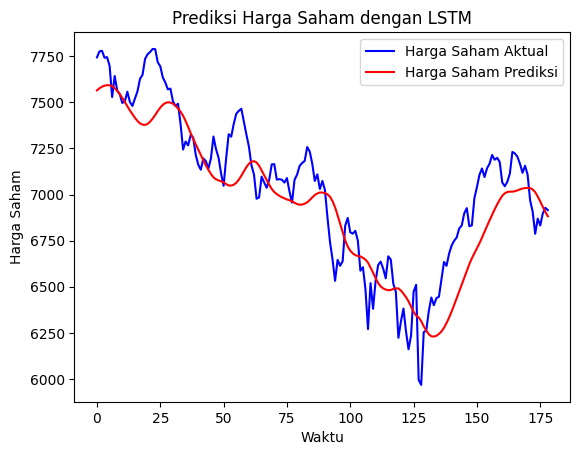

In [105]:
# Memprediksi harga saham pada data testing
predicted_stock_price = model.predict(x_test)

# Mengembalikan harga yang diprediksi ke dalam rentang harga asli
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisasi hasil
import matplotlib.pyplot as plt

plt.plot(y_test_actual, color='blue', label='Harga Saham Aktual')
plt.plot(predicted_stock_price, color='red', label='Harga Saham Prediksi')
plt.title('Prediksi Harga Saham dengan LSTM')
plt.xlabel('Waktu')
plt.ylabel('Harga Saham')
plt.legend()
plt.show()


In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Perhitungan RMSE
rmse = math.sqrt(mean_squared_error(y_test_actual, predicted_stock_price))
print(f"RMSE: {rmse}")

# Perhitungan MAE
mae = mean_absolute_error(y_test_actual, predicted_stock_price)
print(f"MAE: {mae}")

# Perhitungan MAPE
mape = 100 * (abs(y_test_actual - predicted_stock_price) / y_test_actual).mean()
print(f"MAPE: {mape}")


RMSE: 196.7288030301347
MAE: 161.29918001483938
MAPE: 2.3036031242742148


- RMSE (Root Mean Squared Error): Nilai RMSE adalah 205.34, yang menunjukkan kesalahan rata-rata model dalam satuan harga saham sekitar 205.34 unit (misalnya, IDR, USD, dll.). Skala RMSE berada dalam satuan yang sama dengan data asli, yakni harga saham.

- MAE (Mean Absolute Error): Nilai MAE adalah 168.71, yang berarti kesalahan prediksi rata-rata model adalah sekitar 168.71 unit harga saham. Skala MAE juga berada dalam satuan yang sama dengan data asli.

- MAPE (Mean Absolute Percentage Error): Nilai MAPE adalah 2.4%, yang menunjukkan bahwa model memiliki kesalahan rata-rata 2.4% dalam memprediksi harga saham. Skala MAPE berada dalam bentuk persentase, menggambarkan kesalahan relatif terhadap harga aktual.

In [107]:

# Menyimpan model
# model.save('lstm_stock_prediction_model.h5')